# **Histopathologic Cancer Detection: CNN (Keras)**

Table of Contents:
* [About the Data / Problem](#about)
* [Set Up](#setup)
* [Exploratory Data Analysis](#eda)
* [Model Building](#model)
* [Model Training](#modelt)
* [Model Validation](#modelv)
* [Submission](#submission)
* [Conclusion](#conclusion)
* [References](#ref)

<a id="about"></a>
# **About the Data / Problem**

This dataset and task can be found on [Kaggle](http://www.kaggle.com/c/histopathologic-cancer-detection/overview). The overarching task here is to 'create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans'. This task translates well to a binary classification problem. More specifically, a convolutional neural network (CNN) will be used to divide the images from the dataset into two classes, i.e. having cancer and not having cancer. 

The dataset consists of microscopic images of lymph node tissue. Each image has a resolution of 96x96 pixels, and the task will be to identify metastatic cancer tissue in a 32x32 pixel center region of the image. According to the Kaggle competition description, the identification of at least 1 pixel of tumor tissue would effectively label the image as positive, i.e. having cancer. The train dataset consists of 220,025 images, while the test dataset contains 57,468 images. 

As this was my first attempt at developing a CNN using Keras, this project was highly influenced by other works, primarily one by [Pablo Gómez](https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93). All other inspirational works have been listed in the reference section. 

<a id="setup"></a>
# **Set Up**

In [1]:
# Loading necessary libraries
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc 

Using TensorFlow backend.


In [2]:
# Creating paths for train and test data
path = "../input/" 
train_path = path + 'train/'
test_path = path + 'test/'

In [3]:
# Creating a dataframe from the train_path filenames and lables
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
labels = pd.read_csv(path+"train_labels.csv") 
df = df.merge(labels, on = "id") 

,path,id,label
0,../input/train/d43c081bafa286f9c1f7e921883f26c...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/train/092d0eedebce504847715ee046b6ad7...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/train/b0d2582c6218a8764323fc940b41312...,b0d2582c6218a8764323fc940b41312282b99bf4,0


In [4]:
# Viewing the new dataframe
df.head(5)

,path,id,label
0,../input/train/d43c081bafa286f9c1f7e921883f26c...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/train/092d0eedebce504847715ee046b6ad7...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/train/b0d2582c6218a8764323fc940b41312...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/train/187c99df762f13f99818e5593d4bab4...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/train/7c5270c83837de5a5cbb2dca511559d...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [5]:
# Checking the info of the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 3 columns):
path     220025 non-null object
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.7+ MB


In [6]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])     
    return X,y

In [7]:
# Loading 10000 images
N=10000
X,y = load_data(N=N,df=df) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


The code chunks above, inspired by a great [work](https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93/notebook) on this project, converts all images to the unit8 format. This ensures that all images have a pixel format with integer values from 0 to 225. This will also help reduce the memory footprint of this project. I have also loaded in 10000 images for this project. Sticking with a smaller amount of images will also reduce the memory footprint.

<a id="eda"></a>
# **Exploratory Data Analysis**

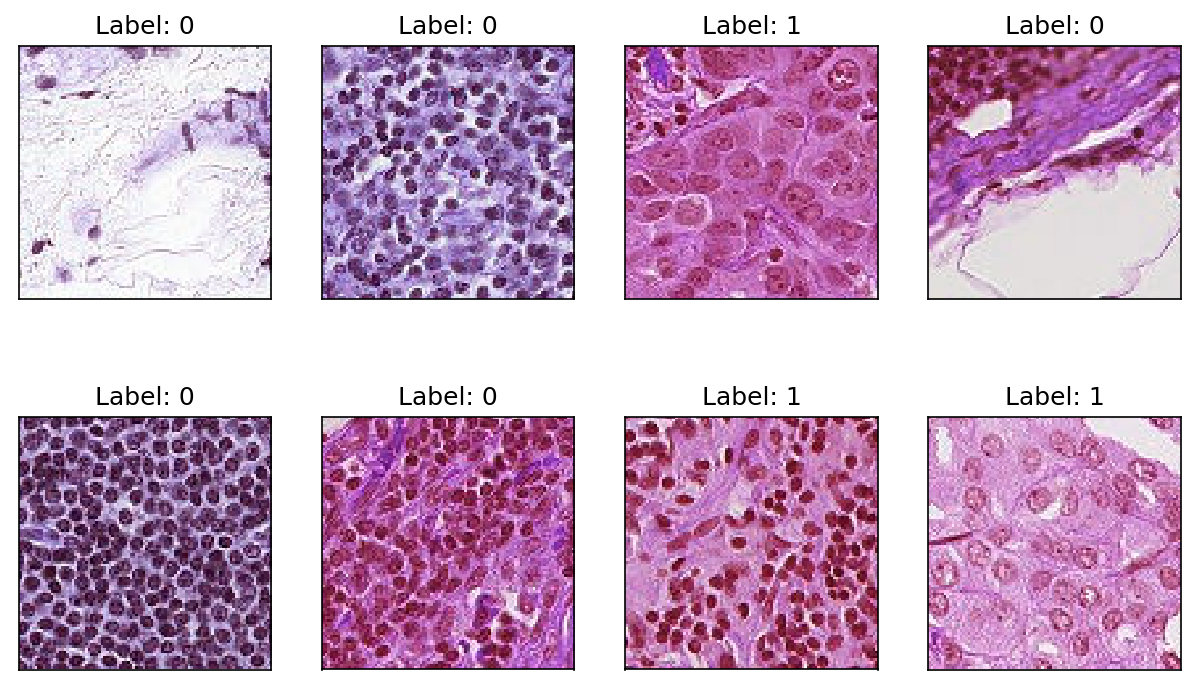

In [10]:
# Visualizing a set of random images
fig = plt.figure(figsize=(10, 6), dpi=150)
np.random.seed(42) 
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) 
    plt.imshow(X[idx]) 
    ax.set_title('Label: ' + str(y[idx])) 

The images above represent random examples of tissue with and without evidence of cancer. Changing the random.seed in the code chunk above will result in different examples being shown. An image labeled as 0 represents tissue WITHOUT cancer and an image labeled as 1 represents tissue WITH cancer. As I have zero knowledge or background in histopathology, it would be unlikely that I could correctly identify a tumor in any given tissue. However, upon visualizing several sets of random images, it seems as though the tissues with large white dots often warrant a positive label. From this, one could deduce that these large white dots are tumors. Although this doesn't necessarily help us here, it is definitely interesting.  

Text(0,0.5,'Samples')

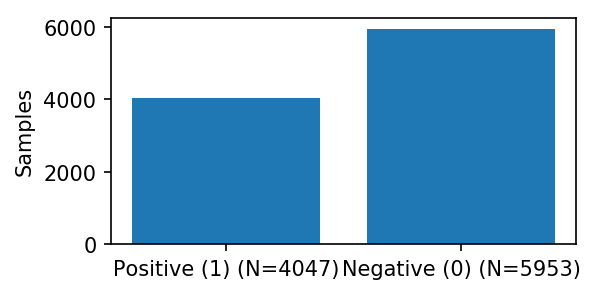

In [12]:
# Visualizing the distribution of positive and negative cases
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); 
plt.xticks([1,0],["Negative (0) (N={})".format((y==0).sum()),"Positive (1) (N={})".format((y==1).sum())]);
plt.ylabel("Samples")

Above, we can see the value counts of each label in the dataset. Overall, there are 5953 negative images and 4047 positive images. In other words, roughly 60% of the dataset contains images of tissue WITHOUT cancer and 40% WITH cancer. 

<a id="model"></a>
# **Model Building**

In [13]:
# Loading images from the training set
N = df["path"].size
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
# Splitting the data into train and validation sets
training_portion = 0.8 
split_idx = int(np.round(training_portion * y.shape[0])) 
np.random.seed(42) 

In [15]:
# Shuffling the data
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

The model below has been inspired by another great [submission](http://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook) to this competition (also listed in the references). 

In [16]:
# Building the model
# Parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

# Dropout for regularization, 0.3 for conv layers, 0.5 for dense layer
dropout_conv = 0.3
dropout_dense = 0.5

# Initializing the model
model = Sequential()

# Building the first conv block
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Building the second conv block
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the third conv block
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the dense layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Converting 0 to 1 using sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [17]:
# Compiling the model
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

Above, we have created our model with three convolutional layers and a dense layer. We will also use a batch size of 50, binary cross entropy and the Adam optimizer with a learning rate of 0.001. 

<a id="modelt"></a>
# **Model Training**

In [18]:
# Training the model for 3 epochs
epochs = 3 
for epoch in range(epochs):
    iterations = np.floor(split_idx / batch_size).astype(int) 
    loss,acc = 0,0 
    with trange(iterations) as t: 
        for i in t:
            start_idx = i * batch_size 
            x_batch = X[start_idx:start_idx+batch_size] 
            y_batch = y[start_idx:start_idx+batch_size] 
            metrics = model.train_on_batch(x_batch, y_batch) 
            loss = loss + metrics[0] 
            acc = acc + metrics[1] 
            t.set_description('Running training epoch ' + str(epoch)) 
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

Running training epoch 2: 100%|██████████| 3520/3520 [02:11<00:00, 26.76it/s, acc=0.91, loss=0.22]


The code chunk above trains the model on 3 epochs. As shown above, the first epoch yields an accuracy of 0.85 and a loss of 0.36. The second yields an accuracy of 0.90 and a loss of 0.26. And the third yields an accuracy of 0.91 and a loss of 0.22. From this, we can see that increasing the number of epochs has both increased accuracy and decreased loss. Any future work on this project could test and see how accuracy and loss would be changed if the number of epochs continues to increase. 

<a id="modelv"></a>
# **Model Validation**

In [19]:
# Performing a validation epoch
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) 
loss,acc = 0,0 
with trange(iterations) as t: 
    for i in t:
        start_idx = i * batch_size 
        x_batch = X[start_idx:start_idx+batch_size] 
        y_batch = y[start_idx:start_idx+batch_size] 
        metrics = model.test_on_batch(x_batch, y_batch) 
        loss = loss + metrics[0] 
        acc = acc + metrics[1] 
        t.set_description('Running training') 
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation: 100%|██████████| 880/880 [00:17<00:00, 51.59it/s, acc=0.92, loss=0.24]

Validation loss: 0.23752959320237013
Validation accuracy: 0.9155227236449719


The code above tests the performance of our model on the validation set. As seen above, the validation accuracy is 0.915 and the loss is 0.237. Both metrics appear to be quite similar to the performance of the model on the training data. 

<a id="submission"></a>
# **Submission**

The code below for creating a submission has been adapted from this [project](https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook).

In [20]:
# Clearing up RAM
X = None
y = None
gc.collect();

In [21]:
# Creating submission path
base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): 
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() 

Indexes: 0 - 5000
5000/5000 [==============================] - 1s 283us/step
Indexes: 5000 - 10000
5000/5000 [==============================] - 1s 231us/step
Indexes: 10000 - 15000
5000/5000 [==============================] - 1s 236us/step
Indexes: 15000 - 20000
5000/5000 [==============================] - 1s 238us/step
Indexes: 20000 - 25000
5000/5000 [==============================] - 1s 234us/step
Indexes: 25000 - 30000
5000/5000 [==============================] - 1s 235us/step
Indexes: 30000 - 35000
5000/5000 [==============================] - 1s 231us/step
Indexes: 35000 - 40000
5000/5000 [==============================] - 1s 230us/step
Indexes: 40000 - 45000
5000/5000 [==============================] - 1s 230us/step
Indexes: 45000 - 50000
5000/5000 [==============================] - 1s 237us/step
Indexes: 50000 - 55000
5000/5000 [==============================] - 1s 236us/step
Indexes: 55000 - 60000
2458/2458 [==============================] - 1s 251us/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.497183
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.007474
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.075605
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.424725
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.482332


In [22]:
# Creating a submission file
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

<a id="conclusion"></a>
# **Conclusion**

In [23]:
# Showing summary of the model used
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
__________

In conclusion, by using the model above with three epochs, I was able to yield an accuracy of 0.91 and a loss of 0.22 on the training data. On the validation data, the accuracy was roughly similar at 0.915 and the loss was 0.24. This project also yielded a public accuracy score of 0.9484 and a private score of 0.937. 

For future works, it may be interesting to either alter the parameters and structure of the Keras model or to increase the number of epochs that were trained on. Regardless, I am quite happy with the score I have obtained, as ~95% accuracy is a great score. However, if this were applied to real life, I would assume that a higher accuracy would be preferred, so as not to incorrectly diagnose cancer tumors in a tissue sample. 

<a id="ref"></a>
# **References**

- https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
- https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
- https://www.kaggle.com/code/abhinand05/histopathologic-cancer-detection-using-cnns#Loading-Data-and-EDA
- https://www.kaggle.com/code/akarshu121/cancer-detection-with-cnn-for-beginners#4.-Validation-and-Analysis
- https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook#Define-the-model
- https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook